# クラスター分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm

In [2]:
np.set_printoptions(precision=2)
%precision %.2f

'%.2f'

In [3]:
df = pd.read_csv("./data/sushi.csv", index_col=0)
df

,tuna,salmon,uni,shellfish,white-flesh_fish
person,,,,,
1,5,3,2,4,5
2,3,4,5,5,3
3,4,5,5,4,4
4,1,2,1,4,4
5,2,2,3,4,3
6,4,4,3,3,3
7,3,3,2,2,3
8,5,5,5,4,3
9,2,1,2,2,1


In [4]:
X = df.values
X

array([[5, 3, 2, 4, 5],
       [3, 4, 5, 5, 3],
       [4, 5, 5, 4, 4],
       [1, 2, 1, 4, 4],
       [2, 2, 3, 4, 3],
       [4, 4, 3, 3, 3],
       [3, 3, 2, 2, 3],
       [5, 5, 5, 4, 3],
       [2, 1, 2, 2, 1],
       [5, 5, 4, 5, 4]], dtype=int64)

# 個体iと個体i'の非類似度 ： ミンコフスキー距離（Minkowski distance）
\begin{align}
d_{ii'} = (\sum^p_{j=1}|x_{ij} - x_{i'j}|^\nu)^\frac{1}{\nu} \quad (\nu &> 0)
\end{align}

$$
    \boldsymbol{X} =
        \left[\begin{array}{ccc}
            x_{11} & \cdots & x_{1p} \\
            \vdots  & \ddots & \vdots \\
            x_{n1} & \cdots & x_{np} \\
        \end{array}\right]
$$

# 1. 階層クラスター分析（hierarchical cluster analysis）

### 要はこの距離の近いものから順番にクラスターを統合していくものらしい。
### とりあえず自分でやってみる。ward法。

$
d(u,v) = \sqrt{\frac{|v|+|s|} {T}d(v,s)^2 + \frac{|v|+|t|} {T}d(v,t)^2 - \frac{|v|} {T}d(s,t)^2}
$

In [5]:
class HierarchicalClusterAnalysis:
    def __init__(self,X):
        self.X = X # データ
        self.N = X.shape[0] # 個体数
        self.cluster = list(range(self.N)) # クラスターの通し番号 初期値[0...n-1] 統合するクラスターを削除し、新たなクラスターを後に追加
        self.num = np.ones(self.N).astype(int).tolist() #各クラスターに入る個体の数 上と同じように更新していく
        self.D = self.calc_all_distances()
    # ミンコフスキー距離
    def minkowski_distance(self, idxs, nu=2):
        # idxs : 距離を計算する2つのindex（tuple or array）
        a = self.X[idxs[0]]
        b = self.X[idxs[1]]
        return (np.sum((b-a)**nu))**(1/nu)
    # 距離を総当たりで計算
    def calc_all_distances(self):
        D = np.diag(np.array([np.inf] * self.N)) # 距離を格納する対象行列(array) 対角成分がargminで選ばれないようにinfを代入
        it = np.nditer(D, flags=['multi_index'])
        while not it.finished:
            idx = it.multi_index
            if idx[0]==idx[1]:
                pass
            else:
                D[idx] = self.minkowski_distance(idx, nu=2)
            it.iternext()
        return D
    # 統合するクラスの判定と計算結果の保存
    def calc_step_result(self):
        step_result = np.zeros(4)
        # 距離最小を計算
        where_to_delete = np.unravel_index(np.argmin(self.D), self.D.shape)
        D_min = self.D[where_to_delete]
        #self.where_to_delete = where_to_delete
        # 結果の保存
        tmp_idx = np.array(where_to_delete).astype(int)
        step_result[0] = self.cluster[tmp_idx[0]]
        step_result[1] = self.cluster[tmp_idx[1]]
        step_result[2] = D_min
        step_result[3] = self.num[where_to_delete[0]] + self.num[where_to_delete[1]]
        return step_result, where_to_delete
    # 新たに作成するクラスタの距離の計算（ward法）
    def ward_method(self, where_to_delete):
        nq = self.num[where_to_delete[0]]
        nr = self.num[where_to_delete[1]]
        ns = nq + nr
        nt = np.array([i for j, i in enumerate(self.num) if j not in where_to_delete])
        dqt = np.delete(self.D[where_to_delete[0], :],where_to_delete)
        drt = np.delete(self.D[where_to_delete[1], :],where_to_delete)
        dqr = self.D[where_to_delete]
        new_distances = ((nq+nt)*dqt + (nr+nt)*drt - nt*dqr) / (ns+nt)
        #new_distances = ( ((nq+nt)*dqt**2 + (nr+nt)*drt**2 - nt*dqr**2)/(ns+nt) )**(1/2) # scikit-learnだとこの式になっているので結果が違う
        return new_distances
    # 距離を格納する行列を更新
    def update_distances(self, where_to_delete, new_distances):
        N = self.D.shape[0]
        _D = np.delete(self.D, where_to_delete, axis=0)
        _D = np.delete(_D, where_to_delete, axis=1)
        next_D = np.diag(np.array([np.inf]*(N-1)))
        next_D[:N-2,:N-2] = _D
        next_D[N-2, :N-2] = new_distances
        next_D[:N-2, N-2] = new_distances
        return next_D
    # メイン
    def main(self):
        result = np.empty((self.N-1, 4))
        for i in range(self.N-1):
            step_result, where_to_delete = self.calc_step_result()
            new_distances = self.ward_method(where_to_delete)
            self.D = self.update_distances(where_to_delete, new_distances)
            self.cluster = [i for j, i in enumerate(self.cluster) if j not in where_to_delete]
            self.num = [i for j, i in enumerate(self.num) if j not in where_to_delete]
            self.cluster.append(self.N + i)
            self.num.append(step_result[3].astype(int))
            result[i] = step_result
        return result


In [6]:
# 実行
ward = HierarchicalClusterAnalysis(X)
my_result = ward.main()
my_result

array([[ 2.  ,  7.  ,  1.41,  2.  ],
       [ 9.  , 10.  ,  1.84,  3.  ],
       [ 5.  ,  6.  ,  2.  ,  2.  ],
       [ 3.  ,  4.  ,  2.45,  2.  ],
       [ 1.  , 11.  ,  2.73,  4.  ],
       [ 0.  , 12.  ,  3.53,  3.  ],
       [ 8.  , 13.  ,  3.96,  3.  ],
       [15.  , 16.  ,  5.58,  6.  ],
       [14.  , 17.  , 11.42, 10.  ]])

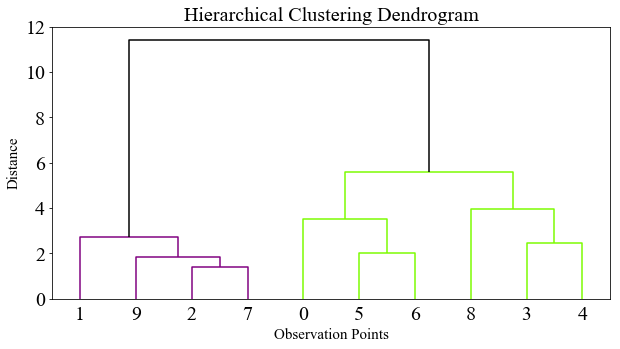

In [7]:
# 結果の描画
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
plt.figure(figsize=(10, 5))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Observation Points', fontsize=15)
plt.ylabel('Distance', fontsize=15)

set_link_color_palette(['purple', 'lawngreen', 'green', 'blue', 'orange', 'red'])
dendrogram(my_result, leaf_font_size=20., color_threshold=7., above_threshold_color='black')
plt.show()

### ライブラリだと一瞬。

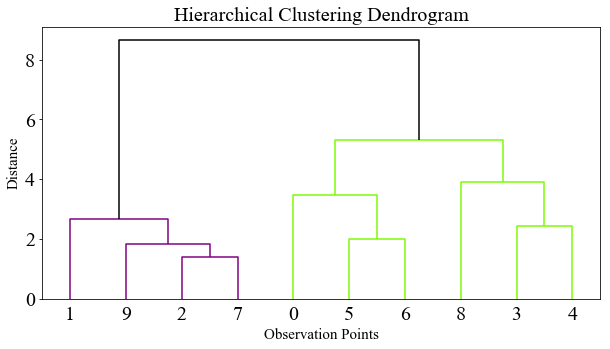

In [8]:
# クラスター分析（ward法）
z = linkage(X, method='ward')

# 図のフォーマットを指定
plt.figure(figsize=(10, 5))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Observation Points', fontsize=15)
plt.ylabel('Distance', fontsize=15)

# デンドログラムの作成
set_link_color_palette(['purple', 'lawngreen', 'green', 'blue', 'orange', 'red'])
dendrogram(z, leaf_font_size=20., color_threshold=7., above_threshold_color='black')
plt.show()

In [9]:
z

array([[ 2.  ,  7.  ,  1.41,  2.  ],
       [ 9.  , 10.  ,  1.83,  3.  ],
       [ 5.  ,  6.  ,  2.  ,  2.  ],
       [ 3.  ,  4.  ,  2.45,  2.  ],
       [ 1.  , 11.  ,  2.68,  4.  ],
       [ 0.  , 12.  ,  3.46,  3.  ],
       [ 8.  , 13.  ,  3.92,  3.  ],
       [15.  , 16.  ,  5.32,  6.  ],
       [14.  , 17.  ,  8.66, 10.  ]])

# 2. 非階層クラスター分析（non-hierarchical cluster analysis）
### k-means methodがよく使われる。らしい。

### 自分でやってみる。

In [10]:
class KMeansMethod:
    def __init__(self, X, k=3):
        self.X = X
        self.N, self.p = X.shape # 個体数,データの次元
        self.X_mean = self.X.mean(axis=0)
        self.k = k # クラスタ数
        self.mu = self.X_mean + np.random.rand(self.k, self.p) # データ全体の平均値付近で初期化
        self.cluster = np.random.randint(0, self.k, self.N) # 各個体が属するクラスタのindexを格納
    def minkowski_distance(self, idxs, nu=2):
        # idxs : 2つのindexが入ったarray
        a = self.X[idxs[0], :]
        b = self.mu[idxs[1], :]
        return (np.sum((b-a)**nu))**(1/nu)
    # 距離を総当たりで計算
    def calc_all_distances(self):
        D = np.zeros((self.N, self.k)) # 距離を格納する行列
        it = np.nditer(D, flags=['multi_index'])
        while not it.finished:
            idx = it.multi_index
            D[idx] = self.minkowski_distance(idx ,nu=2)
            it.iternext()
        return D
    # クラスターへの割り振り
    def make_new_cluster(self):
        self.D = self.calc_all_distances()
        self.new_cluster = np.argmin(self.D,axis=1)
        #print(self.D)
        return self.new_cluster
    # μの更新
    def update_mu(self):
        for k in range(self.k):
            mask = np.where(self.new_cluster==k)
            self.mu[k,:] = self.X[mask].mean(axis=0)
        return None
    # メイン
    def main(self):
        continue_flag = True
        count = 0
        while continue_flag:
            self.make_new_cluster()
            if ((self.new_cluster-self.cluster)**2).sum() < 1e-3: #if self.new_cluster.all == self.cluster.allだとうまく判定しない
                continue_flag = False
            elif count > 100:
                print("error")
                continue_flag = False
            else:
                self.update_mu()
            self.cluster = self.new_cluster
            count += 1
        return self.cluster

In [11]:
# 実行
my_kmeans = KMeansMethod(X)
my_labels = my_kmeans.main()
my_labels

array([1, 2, 2, 0, 0, 0, 0, 2, 0, 2], dtype=int64)

### 可視化しないとなんだかよくわからない

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

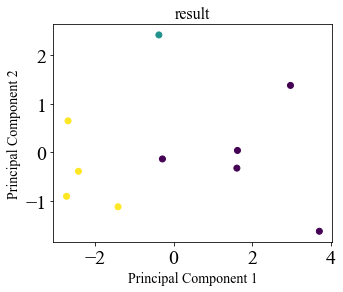

In [13]:
# 可視化
plt.figure(figsize=(5,4))
plt.scatter(X_pca[:, 0],  X_pca[:, 1], c=my_labels)
plt.xlabel('Principal Component 1', size=14)
plt.ylabel('Principal Component 2', size=14)
plt.title('result', size=16)
plt.show()

### ライブラリ

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([0, 2, 2, 1, 1, 0, 0, 2, 1, 2])

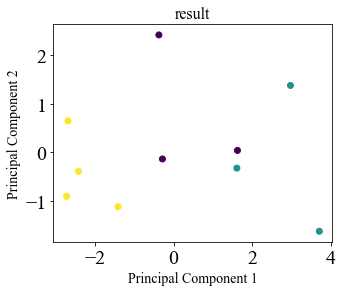

In [15]:
# 可視化
plt.figure(figsize=(5,4))
plt.scatter(X_pca[:, 0],  X_pca[:, 1], c=kmeans.labels_)
plt.xlabel('Principal Component 1', size=14)
plt.ylabel('Principal Component 2', size=14)
plt.title('result', size=16)
plt.show()

### 初期値によって結果は違うらしい。結局よくわからん